In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

In [2]:
consts = {'sigma_threshold': 10, 
          'detect_transits': 3,
          'sector_length': 13.7 #  we are counting in units of orbits
         }

In [25]:
#  uncomment the strategy you want to explore
# strategy = 'SNE'
strategy = 'EC3PO'
# strategy = 'SNSNS'
# strategy = 'SNNSN'

fn = '../data/obs_{}-v3.csv.bz2'.format(strategy)
dfw = pd.read_csv(fn)

In [26]:
print(strategy)
print('Planets detected in primary + extended mission: {}'.format(dfw[dfw.detected].shape[0]))
print('Planets detected in primary mission: {}'.format(dfw[dfw.detected_primary].shape[0]))
print()
print('Planets detected in primary mission: {}'.format(dfw[dfw.detected_primary & dfw.detected].shape[0]))
print('Planets not detected in primary mission but detected in extended mission: {}'.format(
    dfw[~dfw.detected_primary & dfw.detected].shape[0]))
print()
print('Not detected in primary because too few transits and too low SNR: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary < 3) &
    (dfw.SNR_primary < 10)
   ].shape[0]))
print('Not detected in primary because too few transits but high enough: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary < 3) &
    (dfw.SNR_primary >= 10)
   ].shape[0]))
print('Not detected in primary because too too low SNR but enough transits: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary >= 3) &
    (dfw.SNR_primary < 10)
   ].shape[0]))
print()
print('Zero transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 0) &
    (dfw.Ntransits >= 3)
   ].shape[0]))

print('One transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 1) &
    (dfw.Ntransits >= 3)
   ].shape[0]))


print('Two transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 2) &
    (dfw.Ntransits >= 3)
   ].shape[0]))

print()
print('HZ planets smaller than 2.5 Rearth in primary mission: {}'.format(
    dfw.loc[(dfw.detected) & (dfw.inOptimisticHZ) & (dfw.planetRadius < 2.5) & (dfw.detected_primary), :].shape[0]))
print('HZ planets smaller than 2.5 Rearth in extended+primary mission: {}'.format(
    dfw.loc[(dfw.detected) & (dfw.inOptimisticHZ) & (dfw.planetRadius < 2.5) & (~dfw.detected_primary),:].shape[0]))


EC3PO
Planets detected in primary + extended mission: 4605
Planets detected in primary mission: 2469

Planets detected in primary mission: 2469
Planets not detected in primary mission but detected in extended mission: 2136

Not detected in primary because too few transits and too low SNR: 728
Not detected in primary because too few transits but high enough: 301
Not detected in primary because too too low SNR but enough transits: 1107

Zero transits in primary and >3 total: 371
One transits in primary and >3 total: 254
Two transits in primary and >3 total: 404

HZ planets smaller than 2.5 Rearth in primary mission: 16
HZ planets smaller than 2.5 Rearth in extended+primary mission: 31


In [27]:
dfw.loc[dfw.detected, :].to_csv('../data/detected_planet_catalog_{}-v3.csv.bz2'.format(strategy),
                   compression='bz2')

## Warning!
##### I'm lazy and reusing code, the object names listed below are misleading
##### **detected_DF** is for planets detected in primary + extended mission
##### **detected_2min** is for planets detected only in the primary mission

In [6]:
detected_DF = dfw.loc[dfw.detected]
detected_2min = dfw.loc[dfw.detected_primary]

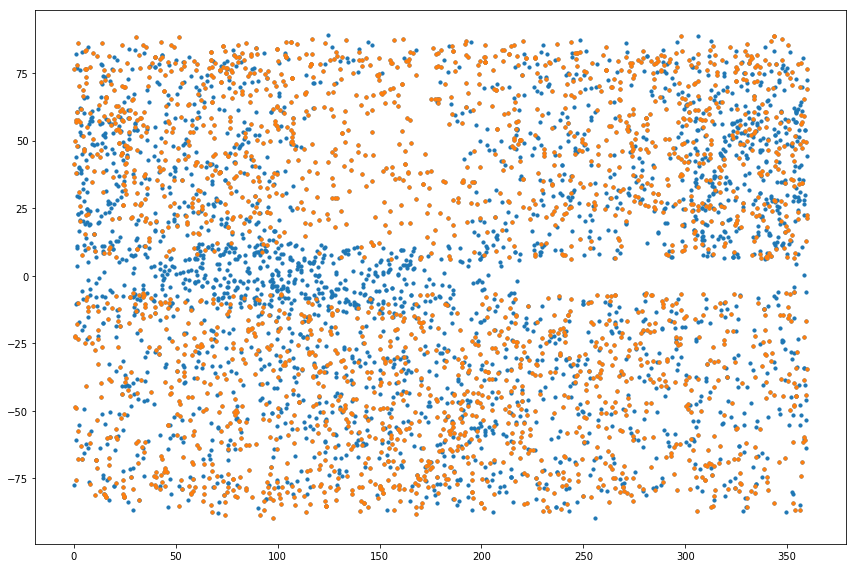

In [7]:
fig, ax = plt.subplots(1,1, figsize=[12, 8])
ax.scatter(dfw.loc[dfw.detected, 'ECLONG'], dfw.loc[dfw.detected, 'ECLAT'], s=10)
ax.scatter(dfw.loc[dfw.detected_primary, 'ECLONG'], dfw.loc[dfw.detected_primary, 'ECLAT'], s=10)
fig.tight_layout()

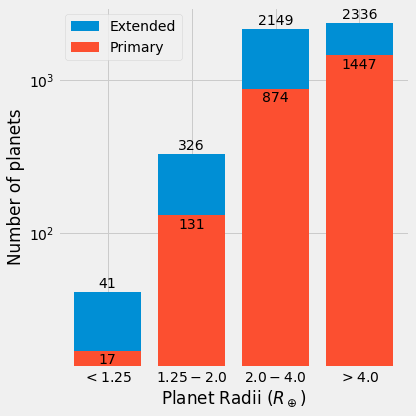

In [8]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+(height*0.02),
                '%d' % int(height),
                ha='center', va='bottom')

def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-(height*0.22),
                '%d' % int(height),
                ha='center', va='bottom')

counts = np.histogram(detected_DF.planetRadius, bins = [0,1.25,2,4,25])
counts2 = np.histogram(detected_2min.planetRadius, bins = [0,1.25,2,4,25])
tl = ['$<1.25$', '$1.25-2.0$', '$2.0-4.0$', '$>4.0$']
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,6])
    
    h1 = ax.bar(np.arange(4), counts[0], tick_label = tl, label='Extended')
    h2 = ax.bar(np.arange(4), counts2[0], tick_label = tl, label='Primary')
    ax.set_xlabel('Planet Radii ($ R_\oplus$)')
    ax.set_ylabel('Number of planets')
#     ax.set_xlim(0,6)
    fig.tight_layout()
    ax.set_yscale('log')
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    autolabel2(h2)
    ax.legend()
    fig.tight_layout()
    fig.savefig('../plots/{}_planetsize.png'.format(strategy), dpi=200)

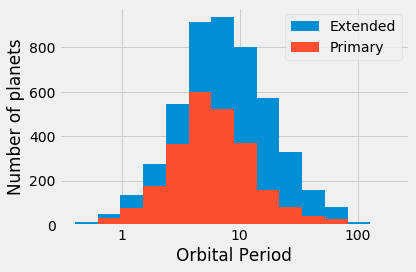

In [9]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,)
    ax.set_xscale('log')
    ax.hist(detected_DF.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15), label='Extended')
    ax.hist(detected_2min.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15), label='Primary')
    from matplotlib.ticker import StrMethodFormatter, NullFormatter
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.legend()
    
    ax.set_xlabel('Orbital Period')
    ax.set_ylabel('Number of planets')
    fig.tight_layout()
    fig.savefig('../plots/{}_porb.png'.format(strategy), dpi=200)

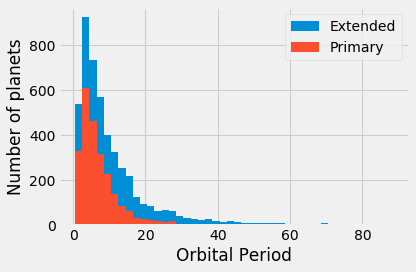

In [10]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,)
#     ax.set_xscale('log')
    ax.hist(detected_DF.planetPeriod, bins=np.arange(0.5,90,2), label='Extended')
    ax.hist(detected_2min.planetPeriod, bins=np.arange(0.5,90,2), label='Primary')
#     ax.hist(detected_2min.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15))
    ax.set_xlabel('Orbital Period')
    ax.set_ylabel('Number of planets')
    ax.legend()
    fig.tight_layout()

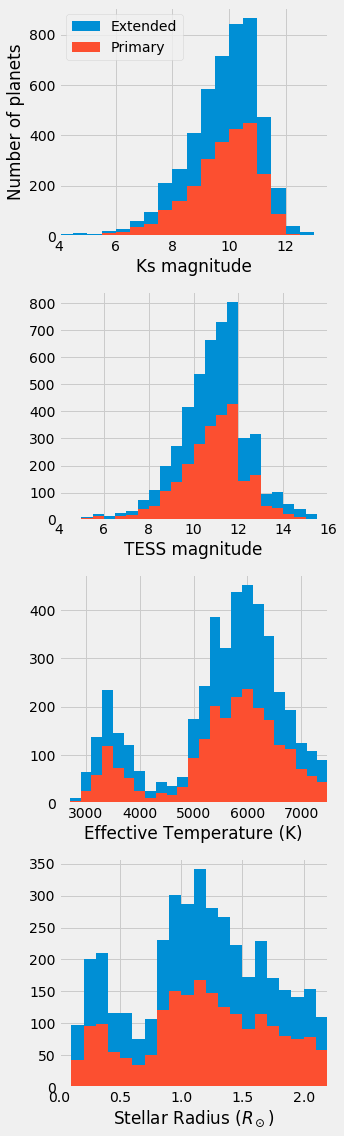

In [11]:
with plt.style.context('fivethirtyeight'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=[5,16])
    
    h1 = ax1.hist(detected_DF.Ks, bins=np.arange(2,16.5,0.5), label='Extended')
    h1 = ax1.hist(detected_2min.Ks, bins=np.arange(2,16.5,0.5), label='Primary')
    ax1.set_xlabel('Ks magnitude')
    ax1.set_ylabel('Number of planets')
    ax1.set_xlim(4,13.5)
    ax1.legend()
    
    h2 = ax2.hist(detected_DF.TESSMAG, bins=np.arange(4,16.5,0.5))
    h2 = ax2.hist(detected_2min.TESSMAG, bins=np.arange(4,16.5,0.5))
    ax2.set_xlabel('TESS magnitude')
    ax2.set_xlim(4,16.0)
    
    h3 = ax3.hist(detected_DF.TEFF, bins=np.arange(2500,7500+250,200))
    h3 = ax3.hist(detected_2min.TEFF, bins=np.arange(2500,7500+250,200))
    ax3.set_xlabel('Effective Temperature (K)')
    ax3.set_xlim(2500,7500)
    
    h4 = ax4.hist(detected_DF.RADIUS, bins=np.arange(0,2.8,0.1))
    h4 = ax4.hist(detected_2min.RADIUS, bins=np.arange(0,2.8,0.1))
    ax4.set_xlabel('Stellar Radius ($R_\odot$)')
    ax4.set_xlim(0,2.2)
    
    fig.tight_layout()
    fig.savefig('../plots/{}_stellar.png'.format(strategy), dpi=200)

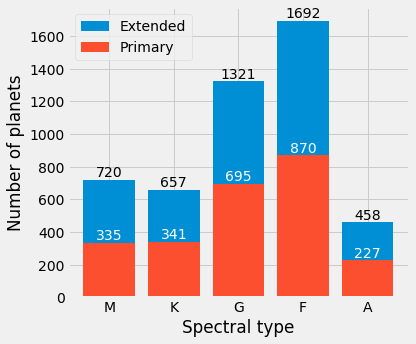

In [12]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+1,
                '%d' % int(height),
                ha='center', va='bottom')

def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-1,
                '%d' % int(height),
                ha='center', va='bottom', color='white')

counts = np.histogram(detected_DF.TEFF, bins = [2285,3905,5310,5980,7330.,10050])
counts2 = np.histogram(detected_2min.TEFF, bins = [2285,3905,5310,5980,7330.,10050])
tl = ['M', 'K', 'G', 'F', 'A']
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,5])
    
    h1 = ax.bar(np.arange(5), counts[0], tick_label = tl, label='Extended')
    h2 = ax.bar(np.arange(5), counts2[0], tick_label = tl, label='Primary')
    ax.set_xlabel('Spectral type')
    ax.set_ylabel('Number of planets')
#     ax.set_xlim(0,6)
    fig.tight_layout()
#     ax.set_yscale('log')
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    autolabel2(h2)
    ax.legend()
    fig.tight_layout()
    fig.savefig('../plots/{}_spectype.png'.format(strategy), dpi=200)

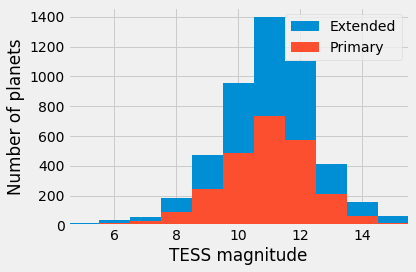

In [13]:
with plt.style.context('fivethirtyeight'):
    fig, ax1 = plt.subplots(1,1,figsize=[6,4])
    
    h1 = ax1.hist(detected_DF.TESSMAG, bins=np.arange(0.5,16.5,1), label='Extended')
    h1 = ax1.hist(detected_2min.TESSMAG, bins=np.arange(0.5,16.5,1), label='Primary')
    ax1.set_xlabel('TESS magnitude')
    ax1.set_ylabel('Number of planets')
    ax1.set_xlim(4.5,15.5)
    ax1.legend()
    
    
    fig.tight_layout()

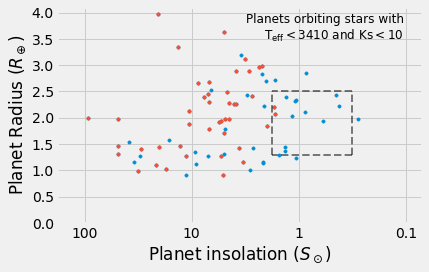

In [14]:
# later than M3
def get_insol(teff, ars):
    p1 = (teff/5771)**4
    p2 = (215.1 / ars)**2
    return p1 * p2

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(get_insol(detected_DF[(detected_DF.TEFF < 3410) & (detected_DF.Ks < 10)].TEFF, 
                         detected_DF[(detected_DF.TEFF < 3410) & (detected_DF.Ks < 10)].ars), 
               detected_DF[(detected_DF.TEFF < 3410) & (detected_DF.Ks < 10)].planetRadius, s=11)
    ax.scatter(get_insol(detected_2min[(detected_2min.TEFF < 3410) & (detected_2min.Ks < 10)].TEFF, 
                         detected_2min[(detected_2min.TEFF < 3410) & (detected_2min.Ks < 10)].ars), 
               detected_2min[(detected_2min.TEFF < 3410) & (detected_2min.Ks < 10)].planetRadius, s=11)
    ax.set_ylim(0,4.1)
    ax.set_xscale("log",)
    ax.set_xlim(180,0.07)

    ax.set_ylabel('Planet Radius ($R_\oplus$)')
    ax.set_xlabel('Planet insolation ($S_\odot$)')
    ax.xaxis.set_ticklabels(['','','0.1','1','10', '100'])
    
    ax.vlines(0.32,1.3,2.5, linestyles='--', alpha=0.5, lw=2)
    ax.vlines(1.78,1.3,2.5, linestyles='--', alpha=0.5, lw=2)
    ax.hlines(2.5,0.32,1.78,linestyles='--', alpha=0.5, lw=2)
    ax.hlines(1.3,0.32,1.78,linestyles='--', alpha=0.5, lw=2)
    ax.text(0.95, 0.9,'Planets orbiting stars with\n$\mathrm{T_{eff}}<$3410 and Ks$<$10', horizontalalignment='right',
        verticalalignment='center',
        transform=ax.transAxes, fontsize=12)

    fig.tight_layout()
    fig.tight_layout()
    fig.savefig('../plots/{}_habzone.png'.format(strategy), dpi=200)

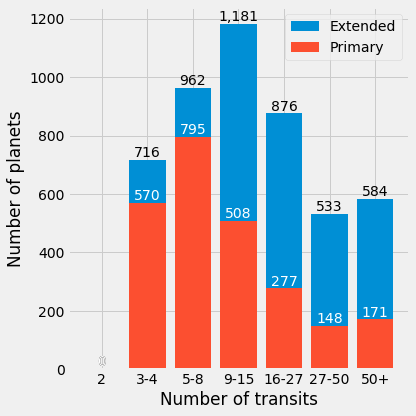

In [15]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+(0),
                "{:,}".format(int(height)),
                ha='center', va='bottom')

def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+(0),
                "{:,}".format(int(height)),
                ha='center', va='bottom', color='white')

counts = np.histogram(detected_DF['Ntransits'], bins = [0.5,2.5,4.5, 8.5,15.5,27.5, 50, 10000])
counts2 = np.histogram(detected_2min['Ntransits_primary'], bins = [0.5,2.5,4.5, 8.5,15.5,27.5, 50, 10000])
# tl = ['$<1.25$', '$1.25 - 2.0$', '$2.0 - 4.0$', '$>4.0$']
tl = ['2', '3-4', '5-8', '9-15', '16-27', '27-50', '50+']
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,6])
    
    h1 = ax.bar(np.arange(7), counts[0], tick_label = tl, label='Extended')
    h2 = ax.bar(np.arange(7), counts2[0], tick_label = tl, label='Primary')
    ax.set_xlabel('Number of transits')
    ax.set_ylabel('Number of planets')
#     ax.set_yscale('log')
#     ax.set_xlim(0,6)
    fig.tight_layout()
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    autolabel2(h2)
    ax.legend()
    fig.tight_layout()
    fig.savefig('../plots/{}_ntransits.png'.format(strategy), dpi=200)

In [16]:
# this doesn't work right now because there is a bug in the new version of Basemap
# I should probably upgrade to cartopy anyway

# from mpl_toolkits.basemap import Basemap
# with plt.style.context('seaborn-paper'):
#     fig, [ax1, ax2] = plt.subplots(2,1, figsize=[5,10])
#     m = Basemap(projection='aeqd',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax2,
#                width=19E6, height=19E6)
#     m.scatter(dfw.loc[dfw.isObserved, 'ECLONG'].values, dfw.loc[dfw.isObserved, 'ECLAT'].values, 
#               s=0.05, alpha=0.2, latlon=True, rasterized=True)

# #     m.scatter(detected_2min.ECLONG.values, detected_2min.ECLAT.values, s=2, lw=1, edgecolor='w',
# #               alpha=1, latlon=True, zorder=100)
#     m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=0.5, edgecolor='w',
#               s=10, alpha=1, latlon=True, zorder=99)
#     m.scatter(detected_2min.ECLONG.values, detected_2min.ECLAT.values, lw=0.5, edgecolor='w',
#               s=10, alpha=1, latlon=True, zorder=100)
    
#     parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
#     m.drawparallels(parallels, latmax=78, )
#     meridians = np.linspace(240-12,360+240-12,14)[:-1]
#     m.drawmeridians(meridians,)

#     m = Basemap(projection='aeqd',lon_0=0,lat_0=-90,resolution='l', ax=ax1, celestial=True,
#                width=19E6, height=19E6)
#     m.scatter(dfw.loc[dfw.isObserved, 'ECLONG'].values, dfw.loc[dfw.isObserved, 'ECLAT'].values, 
#               s=0.05, alpha=0.2, latlon=True, rasterized=True)

# #     m.scatter(detected_2min.ECLONG.values, detected_2min.ECLAT.values, s=2, lw=1, edgecolor='w',
# #               alpha=1, latlon=True, zorder=100)
#     m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=0.5, edgecolor='w',
#               s=10, alpha=1, latlon=True, zorder=99)
#     m.scatter(detected_2min.ECLONG.values, detected_2min.ECLAT.values, lw=0.5, edgecolor='w',
#               s=10, alpha=1, latlon=True, zorder=100)
    
#     parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
#     m.drawparallels(parallels, latmax=78, latmin=-78)
#     meridians = np.linspace(240-12,360+240-12,14)[:-1]
#     m.drawmeridians(meridians, latmax=78, latmin=-78)
#     ax2.set_title('Northern Ecliptic Hemisphere', fontsize=12)
#     ax1.set_title('Southern Ecliptic Hemisphere', fontsize=12)
#     fig.tight_layout()

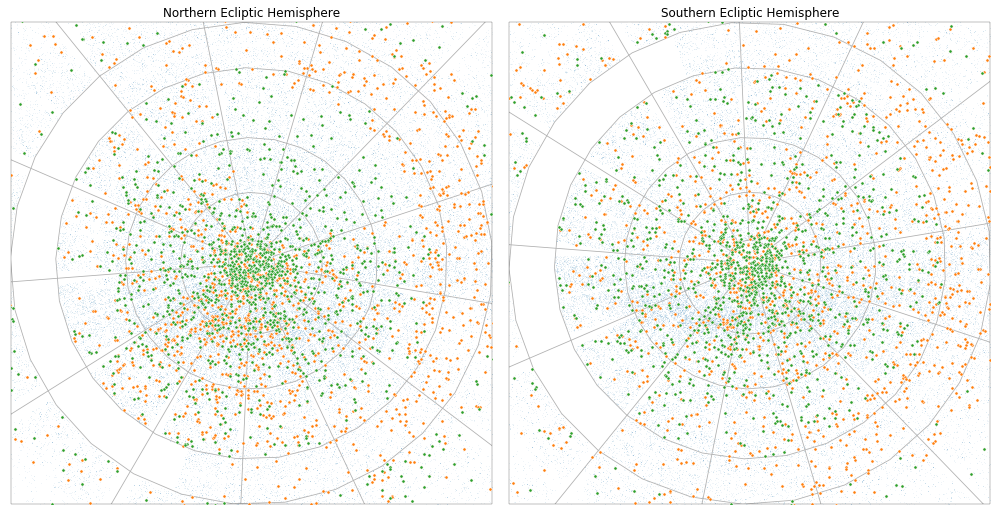

In [17]:

import cartopy.crs as ccrs
with plt.style.context('seaborn-paper'):
    fig = plt.figure(figsize=[14, 14])
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.NorthPolarStereo())
    # ax.set_global()
    ax1.scatter(dfw.loc[dfw.isObserved, 'ECLONG'].values, dfw.loc[dfw.isObserved, 'ECLAT'].values, 
                  s=0.1, alpha=0.2, transform=ccrs.PlateCarree(), rasterized=True)

    ax1.set_extent([-180, 180, 90, -6], ccrs.PlateCarree())
    ax1.gridlines(ylocs=[-78., -54., -30, -6., 6, 30, 54, 78, ], xlocs=np.linspace(240-21,360+240-21,14)[:])
    ax1.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=0.5, edgecolor='w',
                  s=10, alpha=1, zorder=99, transform=ccrs.PlateCarree())
    ax1.scatter(detected_2min.ECLONG.values, detected_2min.ECLAT.values, lw=0.5, edgecolor='w',
                  s=10, alpha=1, zorder=100, transform=ccrs.PlateCarree())
    
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
    ax2.scatter(dfw.loc[dfw.isObserved, 'ECLONG'].values, dfw.loc[dfw.isObserved, 'ECLAT'].values, 
                  s=0.1, alpha=0.2, transform=ccrs.PlateCarree(), rasterized=True)

    ax2.set_extent([-180, 180, -90, +6], ccrs.PlateCarree())
    ax2.gridlines(ylocs=[-78., -54., -30, -6., 6, 30, 54, 78, ], xlocs=np.linspace(240-21,360+240-21,14)[:])
    ax2.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=0.5, edgecolor='w',
                  s=10, alpha=1, zorder=99, transform=ccrs.PlateCarree())
    ax2.scatter(detected_2min.ECLONG.values, detected_2min.ECLAT.values, lw=0.5, edgecolor='w',
                  s=10, alpha=1, zorder=100, transform=ccrs.PlateCarree())
    
    ax1.set_title('Northern Ecliptic Hemisphere', fontsize=12)
    ax2.set_title('Southern Ecliptic Hemisphere', fontsize=12)
    fig.tight_layout()
    fig.savefig('../plots/skyplot_{}.png'.format(strategy),)

In [22]:
print('Planets detected in primary mission: {}'.format(dfw[dfw.detected_primary & dfw.detected].shape[0]))
print('Planets not detected in primary mission but detected in extended mission: {}'.format(
    dfw[~dfw.detected_primary & dfw.detected].shape[0]))
print()
print('Not detected in primary because too few transits and too low SNR: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary < 3) &
    (dfw.SNR_primary < 10)
   ].shape[0]))
print('Not detected in primary because too few transits but high enough: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary < 3) &
    (dfw.SNR_primary >= 10)
   ].shape[0]))
print('Not detected in primary because too too low SNR but enough transits: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary >= 3) &
    (dfw.SNR_primary < 10)
   ].shape[0]))
print()
print('Zero transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 0) &
    (dfw.Ntransits >= 3)
   ].shape[0]))

print('One transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 1) &
    (dfw.Ntransits >= 3)
   ].shape[0]))


print('Two transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 2) &
    (dfw.Ntransits >= 3)
   ].shape[0]))

print()
print('HZ planets smaller than 2.5 Rearth in primary mission: {}'.format(
    dfw.loc[(dfw.detected) & (dfw.inOptimisticHZ) & (dfw.planetRadius < 2.5) & (dfw.detected_primary), :].shape[0]))
print('HZ planets smaller than 2.5 Rearth in extended+primary mission: {}'.format(
    dfw.loc[(dfw.detected) & (dfw.inOptimisticHZ) & (dfw.planetRadius < 2.5) & (~dfw.detected_primary),:].shape[0]))


Planets detected in primary mission: 2469
Planets not detected in primary mission but detected in extended mission: 2383

Not detected in primary because too few transits and too low SNR: 682
Not detected in primary because too few transits but high enough: 462
Not detected in primary because too too low SNR but enough transits: 1239

Zero transits in primary and >3 total: 289
One transits in primary and >3 total: 228
Two transits in primary and >3 total: 627

HZ planets smaller than 2.5 Rearth in primary mission: 16
HZ planets smaller than 2.5 Rearth in extended+primary mission: 45


In [19]:
print('Not detected in primary because too few transits and too low SNR: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary < 3) &
    (dfw.SNR_primary < 10)
   ].shape[0]))
print('Not detected in primary because too few transits but high enough: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary < 3) &
    (dfw.SNR_primary >= 10)
   ].shape[0]))
print('Not detected in primary because too too low SNR but enough transits: {}'.format(dfw[~dfw.detected_primary &
    dfw.detected &
    (dfw.Ntransits_primary >= 3) &
    (dfw.SNR_primary < 10)
   ].shape[0]))

Not detected in primary because too few transits and too low SNR: 682
Not detected in primary because too few transits but high enough: 462
Not detected in primary because too too low SNR but enough transits: 1239


In [20]:
print('Zero transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 0) &
    (dfw.Ntransits >= 3)
   ].shape[0]))

print('One transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 1) &
    (dfw.Ntransits >= 3)
   ].shape[0]))


print('Two transits in primary and >3 total: {}'.format(dfw[dfw.detected &
    (dfw.Ntransits_primary == 2) &
    (dfw.Ntransits >= 3)
   ].shape[0]))



Zero transits in primary and >3 total: 289
One transits in primary and >3 total: 228
Two transits in primary and >3 total: 627


In [21]:
print('HZ planets smaller than 2.5 Rearth in primary mission: {}'.format(
    dfw.loc[(dfw.detected) & (dfw.inOptimisticHZ) & (dfw.planetRadius < 2.5) & (dfw.detected_primary), :].shape[0]))
print('HZ planets smaller than 2.5 Rearth in extended+primary mission: {}'.format(
    dfw.loc[(dfw.detected) & (dfw.inOptimisticHZ) & (dfw.planetRadius < 2.5) & (~dfw.detected_primary),:].shape[0]))



HZ planets smaller than 2.5 Rearth in primary mission: 16
HZ planets smaller than 2.5 Rearth in extended+primary mission: 45
